# Geologic profiles -  Mount Alpi (Lucania, Southern Italy)

*Doc started 2019-05-12*

*Current version: 2024-08-11*

*Last running version: 2024-08-13*

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile. 

Figures are plotted via matplotlib:

In [1]:
%matplotlib inline

Data sets can be plotted with pprint:

In [2]:
from pprint import pprint

## Defining the DEM input

The source DEM is from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [3]:
from gst.spatdata.load_data import load

grid = load(
    area = 'mt_alpi', 
    type = 'DEM')

In [4]:
grid

Grid with 260 rows and 213 columns - EPSG code 32633

We can plot this grid with a utility function:

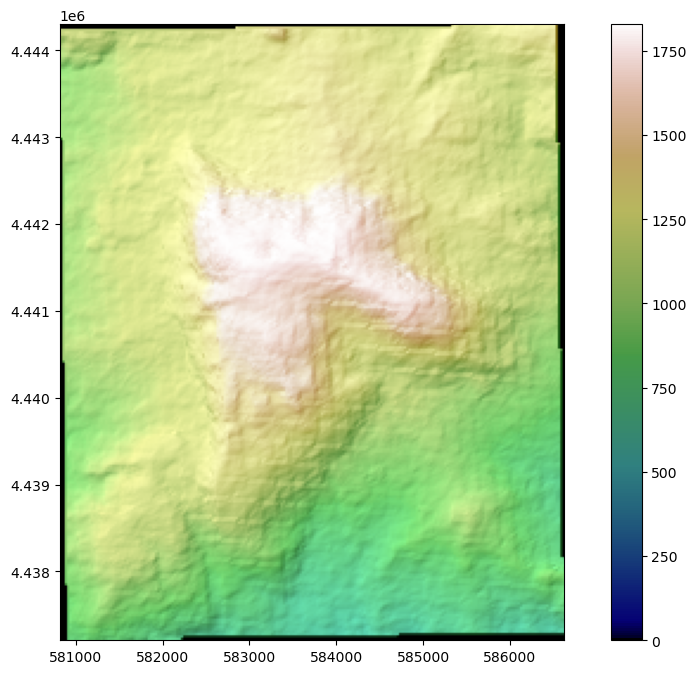

In [5]:
from gst.plots.parameters import *
from gst.plots.maps import *

figure_parameters = FigureParams(
    width=12,
    height=8
)

maps(
    grid,
    fig_params=figure_parameters
)

## Source profile definition

In order to digitally create a topographic/geological profile, we first need to define a trace with wich to extract elevations from DEMs and afterwards to manipulate geological layers. 

In this example, we read the trace from a line shapefile using a function based on GDAL/OGR.

In [6]:
profile = load(
    area = 'mt_alpi', 
    type = 'profile')

In [7]:
profile

Ln with 2 point(s): Point([ 581981.18800849 4442999.21438272]), Point([ 586203.57228441 4440126.19046866])

Since the spatial reference of the line profile is EPSG: 32633, i.e. the same as that of raster DEM CRS, no projection change is required before plotting against the DEM.

Now we plot the profile trace in a figure.

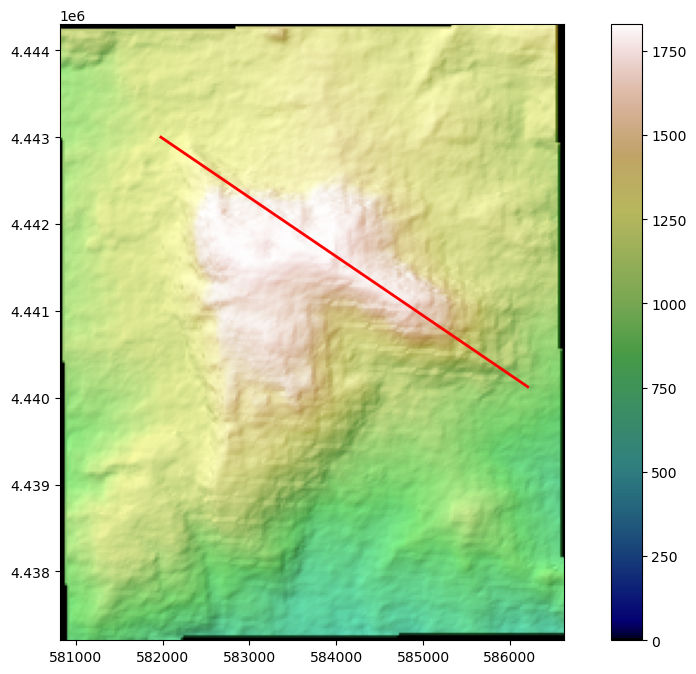

In [8]:
figure_parameters = FigureParams(
    width=12,
    height=8
)

profile_parameters = ElevationPlotParams(
    color="red",
    width=2.0,
)

maps(        
    grid,
    lines = {
        'profile': {'data': [profile], 'params': profile_parameters},
    },
    fig_params=figure_parameters
)

### Reading geological attitudes

A few geological attitudes in the proximity of the profiles are available in a point shapefile.

The projection of the source dataset is UTM33, as are the DEM and the profile, so we do not need any reprojection.

In [9]:
from gst.core.profiles.methods import attitudes_3d_from_grid

attitudes_3d = load("mt_alpi", "attitudes")

In [10]:
print(attitudes_3d)

[(1, Point([5.83531375e+05 4.44161440e+06 1.76556861e+03]), Plane(090.00, +18.00)), (2, Point([5.83771704e+05 4.44189509e+06 1.75692514e+03]), Plane(095.00, +30.00)), (3, Point([5.84184366e+05 4.44126922e+06 1.63303396e+03]), Plane(072.00, +26.00)), (4, Point([5.84722156e+05 4.44107152e+06 1.69753771e+03]), Plane(075.00, +40.00)), (5, Point([5.82878687e+05 4.44210586e+06 1.61465027e+03]), Plane(080.00, +15.00)), (6, Point([5.84266849e+05 4.44120876e+06 1.63630571e+03]), Plane(060.00, +25.00)), (7, Point([5.84249684e+05 4.44118248e+06 1.59342279e+03]), Plane(030.00, +15.00)), (8, Point([5.84838631e+05 4.44092573e+06 1.62696115e+03]), Plane(070.00, +35.00)), (9, Point([5.84644096e+05 4.44135393e+06 1.62694205e+03]), Plane(105.00, +40.00)), (10, Point([5.85641114e+05 4.44044818e+06 1.16620891e+03]), Plane(135.00, +21.00)), (11, Point([5.85200730e+05 4.44108430e+06 1.52778723e+03]), Plane(080.00, +30.00))]


Now the attitudes have a 3D point. We can therefore proceed calculating the projections of the attitude on the section. 

### Creating the Profilers instance

We create a Profilers instance, by defining the number of parallel profilers to create and their lateral offset (i.e., the perpendicular spacing between them). In this case we create a single profile. 

In [11]:
from gst.core.profiles.profilers import Profilers

profilers = Profilers(
    src_trace=profile,
    num_profiles=1,
)

The result can be displayed as a map with the 'maps' function:

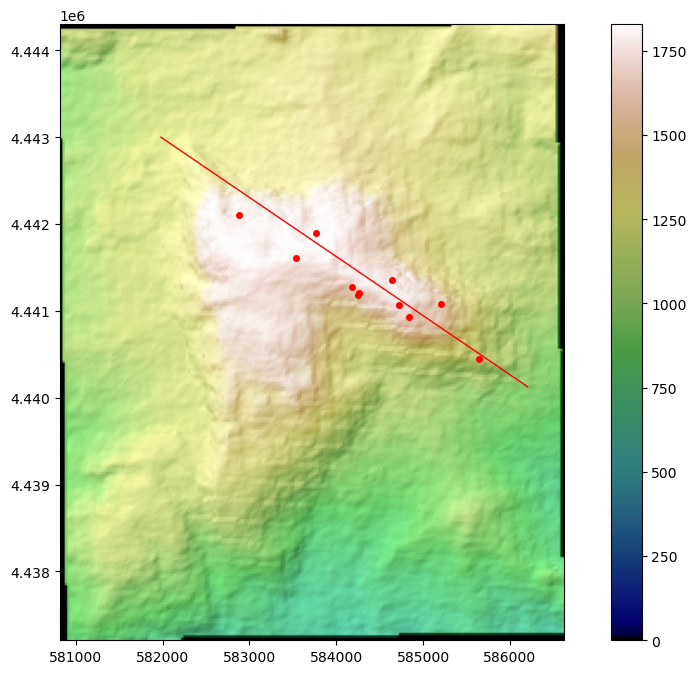

In [12]:
attitudes_list = [point for _, point, _ in attitudes_3d]

maps(        
    grid,
    lines = {
        'profile': {
            'data': profilers.lines, 
            'params': ElevationPlotParams(
                color="red",
                width=1.0,
            )
        },
    },
    points = {
        'attitudes': {
            'data': attitudes_list,
            'params': AttitudePlotParams(
                marker = 'o',
                markersize = 4,
                color = "red",
                alpha = 1.0,
                labels = False
            )
        },
    },
    fig_params = FigureParams(
        width=12,
        height=8
    )
)


## Creating a geological profile

In [13]:
from gst.core.profiles.geoprofiles import GeoProfiles

geoprofiles = GeoProfiles(profilers=profilers)

In [14]:
err = geoprofiles.sample_grid(
    grid=grid,
    sampling_distance=10 # meters
)
assert not err

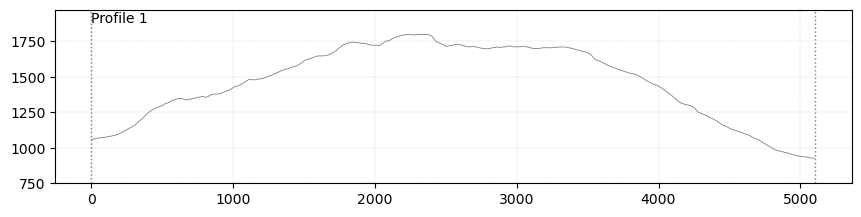

In [15]:
from gst.plots.profiles import *

fig = profiles(
    geoprofiles,
    aspect=1, 
    linewidth=0.8,
    height=5,
    elevation_params=ElevationPlotParams(
        color="gray",
        width=0.6
    )
)

## Adding geological attitudes to profiles

In [16]:
err = geoprofiles.project_points(
    data=attitudes_3d,
    max_profile_distance = 500, # meters
    projection_method=ProjectionMethod.NEAREST,
    input_type=PointsInput.ATTITUDES,
    cat_key="stratifications",
)
print(err)

In [17]:
geoprofiles._points_projections

{'stratifications': [defaultdict(gst.core.profiles.profiletraces.PlaneTrace,
              {1: PlaneTrace(s=2060.67, z=1765.57, dip_angle=15.04, down_sense=right, dist=272.85, src_dip_dir=90.00, src_dip_ang=18.00),
               2: PlaneTrace(s=2101.46, z=1756.93, dip_angle=26.74, down_sense=right, dist=94.41, src_dip_dir=95.00, src_dip_ang=30.00),
               3: PlaneTrace(s=2794.72, z=1633.03, dip_angle=16.63, down_sense=right, dist=190.89, src_dip_dir=72.00, src_dip_ang=26.00),
               4: PlaneTrace(s=3350.56, z=1697.54, dip_angle=28.72, down_sense=right, dist=51.81, src_dip_dir=75.00, src_dip_ang=40.00),
               5: PlaneTrace(s=1244.57, z=1614.65, dip_angle=10.87, down_sense=right, dist=233.70, src_dip_dir=80.00, src_dip_ang=15.00),
               6: PlaneTrace(s=2896.92, z=1636.31, dip_angle=11.46, down_sense=right, dist=194.48, src_dip_dir=60.00, src_dip_ang=25.00),
               7: PlaneTrace(s=2897.51, z=1593.42, dip_angle=1.13, down_sense=left, dist=225.86, 

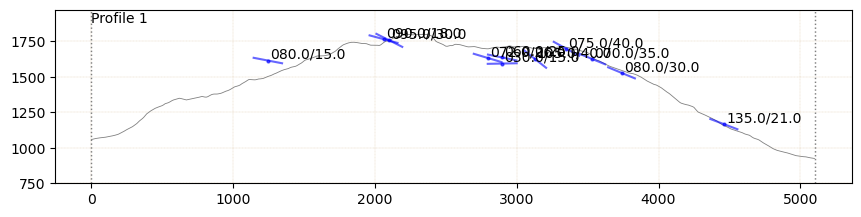

In [18]:
fig = profiles(
    geoprofiles,
    aspect=1, 
    linewidth=0.8,
    height=5,
    elevation_params=ElevationPlotParams(
        color="gray",
        width=0.6
    ),
    stratifications = AttitudePlotParams(
                marker = 'o',
                markersize = 2,
                color = "blue",
                alpha = 0.6,
                labels=True,
            )
)

In [19]:
bool(err)

False